In [1]:
!pip install -U pip

    100% |████████████████████████████████| 1.5MB 13.9MB/s ta 0:00:01
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
You are using pip version 20.1.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install transformers

     |████████████████████████████████| 660 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 675 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 60.5 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 59.9 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893264 sha256=1e452efef555f61f509c8ba0e02c0f8f6f902d14d2eea50db79a9d5e90f2920b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses


In [3]:
import torch
from transformers import BertModel, BertTokenizer
import boto3

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [5]:
# 定数
BUCKET_NAME = "movie-recommender-ml-9353-2684-4264"
OBJECT_KEY = "data/movies.tsv"

# データの取得
s3 = boto3.resource("s3")
bucket = s3.Bucket(BUCKET_NAME)
obj = bucket.Object(OBJECT_KEY)
content = obj.get()["Body"].read().decode("utf-8")

In [6]:
# Bertモデルのロード
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [7]:
def encode(overview, device, tokenizer):
    ids = tokenizer.encode(overview)
    ids = torch.LongTensor(ids)
    ids = ids.to(device)
    return ids.unsqueeze(0)

In [8]:
def embedding(overview, model):
    out = model(input_ids=overview)
    hidden_states = out[2]
    sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
    return sentence_embedding

In [9]:
embeddings = {}
with torch.no_grad():
    for i, row in enumerate(content.split("\n")):
        if i == 0:
            continue
        if len(row.split("\t")) < 3:
            continue
        movie_id, title, overview = row.split("\t")
        overview = encode(overview, device, tokenizer)
        sentence_embedding = embedding(overview, model)
        embeddings[title] = sentence_embedding

In [10]:
import pandas as pd
from torch.nn import CosineSimilarity

cos = CosineSimilarity(dim=1, eps=1e-6)

In [31]:
sim_mat = {}
for i, i_embedding in embeddings.items():
    sim_mat[i] = []
    for j, j_embedding in embeddings.items():
        sim_mat[i].append(cos(i_embedding.unsqueeze(0), j_embedding.unsqueeze(0)).numpy()[0])

In [32]:
df = pd.DataFrame.from_dict(sim_mat)

In [33]:
df.index = list(embeddings.keys())

In [34]:
df

,Se7en,Fight Club,The Silence of the Lambs,Star Wars: Episode I - The Phantom Menace,Star Wars: Episode II - Attack of the Clones,Toy Story,Toy Story 2,Back to the Future,Finding Nemo,もののけ姫
Se7en,1.000000,0.814675,0.869972,0.741315,0.679290,0.740019,0.786135,0.790225,0.785805,0.791170
Fight Club,0.814675,1.000000,0.807927,0.743305,0.713421,0.780952,0.831383,0.823054,0.818595,0.756937
The Silence of the Lambs,0.869972,0.807927,1.000000,0.787159,0.719146,0.756720,0.817006,0.792403,0.797807,0.800682
Star Wars: Episode I - The Phantom Menace,0.741315,0.743305,0.787159,1.000000,0.864042,0.746756,0.771561,0.760998,0.725159,0.812547
Star Wars: Episode II - Attack of the Clones,0.679290,0.713421,0.719146,0.864042,1.000000,0.677848,0.724453,0.744472,0.661070,0.729285
Toy Story,0.740019,0.780952,0.756720,0.746756,0.677848,1.000000,0.919511,0.840042,0.829979,0.769098
Toy Story 2,0.786135,0.831383,0.817006,0.771561,0.724453,0.919511,1.000000,0.863449,0.870451,0.796050
Back to the Future,0.790225,0.823054,0.792403,0.760998,0.744472,0.840042,0.863449,1.000000,0.832324,0.813708
Finding Nemo,0.785805,0.818595,0.797807,0.725159,0.661070,0.829979,0.870451,0.832324,1.000000,0.807485
もののけ姫,0.791170,0.756937,0.800682,0.812547,0.729285,0.769098,0.796050,0.813708,0.807485,1.000000


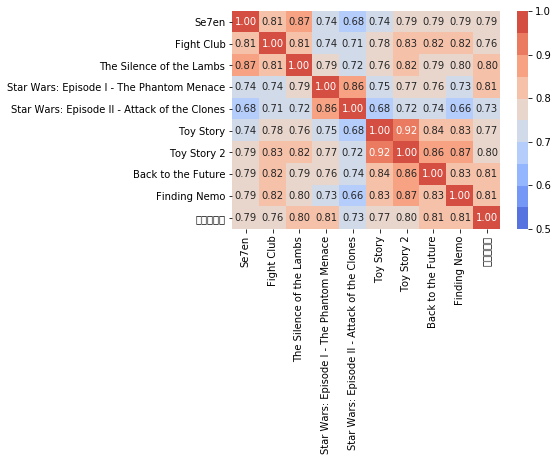

In [37]:
%matplotlib inline
import seaborn as sns
sns.heatmap(df, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = 0.5, vmax = 1);